---
# Import libraries
---

In [204]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re
from datetime import datetime


import seaborn as sns 

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tag import UnigramTagger,pos_tag
from nltk import bigrams, ngrams

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn import linear_model
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn import metrics

from gensim.models import Word2Vec

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mehdi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mehdi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mehdi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mehdi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\mehdi\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


---
# Data Importation
---

In [12]:
df=pd.read_csv("https://drive.google.com/uc?id=1r3ZwNtY1f7lWrYKgC-hk0GJCcoxSuTej",sep=";")

In [13]:
df.head()

,date,note,auteur,avis,assureur,produit
0,06 septem...,5,brahim--k-131532,"Meilleurs assurances, prix, solutions, écoute,...",Direct Assurance,auto
1,03 mai 20...,4,bernard-g-112497,"je suis globalement satisfait , sauf que vous ...",Direct Assurance,auto
2,21 mars 2...,5,virginie-t-107352,Prix tres abordable plusieurs options s'offren...,Direct Assurance,auto
3,10 juin 2...,4,boulain-f-116580,"je satisfait du service, une réponse très rapi...",L'olivier Assurance,auto
4,29 janvie...,1,ouaille31-51798,"Client depuis plus de 25 ans, très déçu de cet...",Matmut,auto


---
# Data processing / cleaning
---

In [14]:
df['date'] = df['date'].apply(lambda x: x.strip())

In [60]:
# Let's first clean the date column, the most obvious one
def get_dates(data):
    
    reg_ = re.match("(\d+) (.+) suite à une expérience en (.+)",data).groups()
    
    return reg_[1], reg_[2]

all_dates = list(df['date'].apply(get_dates))

In [61]:
rate_date = [d[0] for d in all_dates]
exp_date = [d[1] for d in all_dates]

In [64]:
tmp = pd.Series([d.split()[0] for d in rate_date]).unique()

In [65]:
# Let's associate every month to a number
def to_dtime(data):
    
    map_month = {'janvier' : 1,
            'février' : 2,
            'mars' : 3,
            'avril' : 4,
            'mai' : 5,
            'juin' : 6,
            'juillet' : 7,
            'août' : 8,
            'septembre' : 9,
            'octobre' : 10,
            'novembre' : 11,
            'décembre' : 12}
    
    split = data.split()
    split[0] = str(map_month[split[0]])
    new_data = "/".join(split)
    return datetime.strptime(new_data,"%m/%Y")

In [68]:
df['rate_date'] = [to_dtime(d) for d in rate_date]
df['exp_date'] = [to_dtime(d) for d in exp_date]

---
### Difference between the rating date and the sinister
---

In [23]:
def get_diff(x):
    start_date = x['exp_date']
    end_date = x['rate_date']
    return (end_date.year - start_date.year) * 12 + (end_date.month - start_date.month)

In [24]:
df['date_difference'] = df.apply(get_diff,axis=1)

In [25]:
df.groupby('date_difference').count()

,date,note,auteur,avis,assureur,produit,rate_date,exp_date
date_difference,,,,,,,,
0,23902,23902,23901,23901,23902,23902,23902,23902
1,73,73,73,73,73,73,73,73
2,17,17,17,17,17,17,17,17
3,17,17,17,17,17,17,17,17
4,9,9,9,9,9,9,9,9
5,9,9,9,9,9,9,9,9
6,4,4,4,4,4,4,4,4
7,8,8,8,8,8,8,8,8
8,5,5,5,5,5,5,5,5


In [26]:
df['date'].apply(lambda x : 1 if re.match("(\d+) (.+) suite à une expérience en (.+)",x).groups() else 0)

0        1
1        1
2        1
3        1
4        1
        ..
24100    1
24101    1
24102    1
24103    1
24104    1
Name: date, Length: 24105, dtype: int64

---
## Let's process the Review Column
---

In [27]:
def tokenize(x):
    try :
        return word_tokenize(x)
    except:
        return None

In [28]:
tokenised_cat = df['avis'].apply(tokenize)

In [69]:
# Function to take care of the case of an empty review
def handle_None():
  for i in range(len(tokenised_cat)):
    if tokenised_cat[i]==None:
      tokenised_cat[i]=""
handle_None()

In [30]:
avis_tokenized=[[x.lower() for x in el] for el in tokenised_cat] 

In [31]:
avis_without_specials = [[x for x in el if re.match('[a-z]+',str(x))] for el in avis_tokenized]

In [32]:
avis_without_specials = [[x for x in el if re.sub('[^a-z]+'," ",str(x))] for el in avis_without_specials]

In [33]:
all_stopwords=stopwords.words('french')
avis_without_stopwords=[[x for x in el if x not in all_stopwords] for el in avis_without_specials]

In [34]:
lemmatizer = WordNetLemmatizer()
avis_lemmetized = [[lemmatizer.lemmatize(str(word)) for word in el] for el in avis_without_stopwords]

In [35]:
# Categorize produit and assureur
df['produit_cat']=df['produit'].astype('category').cat.codes.astype('int64')
df['assureur_cat']=df['assureur'].astype('category').cat.codes.astype('int64')

---
# Data exploration
---

In [72]:
print('Amount of null values per column (%) :\n')
for col in df.columns:
    res = (df[col].isnull().sum() / len(df)) * 100
    res = round(res,2)
    print(f'   - {col} : {res}%')
print('As we can see, no column has null values')

Amount of null values per column (%) :

   - date : 0.0%
   - note : 0.0%
   - auteur : 0.0%
   - avis : 0.0%
   - assureur : 0.0%
   - produit : 0.0%
   - rate_date : 0.0%
   - exp_date : 0.0%
   - date_difference : 0.0%
   - produit_cat : 0.0%
   - assureur_cat : 0.0%
As we can see, no column has null values


### Let's first look at users

In [266]:
df2=pd.DataFrame(df['auteur'].value_counts())
df2.iloc[:10,:]
# Users that used their insurance the most

,auteur
mm-53953,4
mikado-50419,4
pj-97010,4
tontonbubu-54321,4
draeni-58258,3
laurent-61923,3
tigefranck-69006,3
cedric-70862,3
fredo92-63526,3
coupat-51116,3


### Let's look at the rate dates

<AxesSubplot:xlabel='rate_date'>

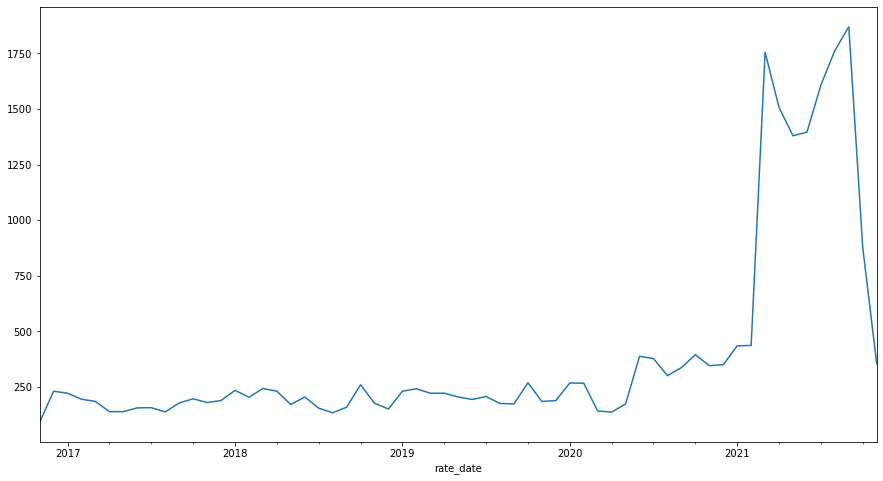

In [75]:
plt.figure(figsize=(15,8))
df.groupby(['rate_date'])['produit'].size().plot()
# We can see a big spike in 2021

### Let's now look at the ratings

<AxesSubplot:xlabel='rate_date'>

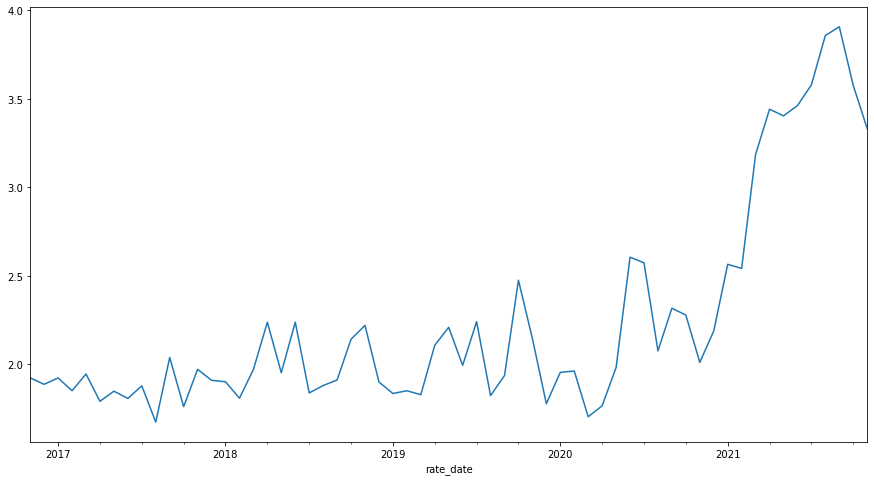

In [76]:
plt.figure(figsize=(15,8))
df.groupby(['rate_date']).mean()['note'].plot()
# We can also see a big spike starting in 2021, going from around 2 to around 3.5

### Let's now look at products

In [84]:
df1=pd.DataFrame(df['produit'].value_counts())
df1.style
# Auto are the most present

,produit
auto,14077
sante,3525
moto,2105
habitation,1956
prevoyance,791
credit,653
vie,578
animaux,374
multirisque-professionnelle,20
garantie-decennale,12


In [86]:
# Best rated types of products
df_rates2=pd.DataFrame(df.groupby('produit').mean()['note'].sort_values(ascending=False))
df_rates2.iloc[:10,:]

,note
produit,
moto,3.501188
auto,3.145343
multirisque-professionnelle,2.850000
credit,2.647779
sante,2.531348
animaux,1.820856
habitation,1.738753
prevoyance,1.661188
garantie-decennale,1.583333


### Let's now look at insurances

In [268]:
# Most used assureurs
df_rates1=pd.DataFrame(df.groupby('assureur').count()['note'].sort_values(ascending=False))
df_rates1.iloc[:10,:]

,note
assureur,
Direct Assurance,5896
L'olivier Assurance,4288
APRIL Moto,1023
GMF,998
Néoliane Santé,861
MACIF,829
AMV,688
Santiane,658
AXA,629


In [269]:
# Best rated insurances
df_rates1=pd.DataFrame(df.groupby('assureur').mean()['note'].sort_values(ascending=False))
df_rates1.iloc[:10,:]

,note
assureur,
Zen'Up,4.436735
APRIL Moto,3.946237
Mapa,3.900000
L'olivier Assurance,3.829757
AMV,3.691860
Peyrac Assurances,3.642857
MGP,3.589686
Santiane,3.468085
Direct Assurance,3.314790


### Let's explore "avis"

In [88]:
len(avis_lemmetized) 
# Number of total reviews (number of rows)

24105

In [90]:
avis_fin=[]
for i in range(len(avis_lemmetized)):
  avis_fin.append(' '.join(avis_lemmetized[i]))

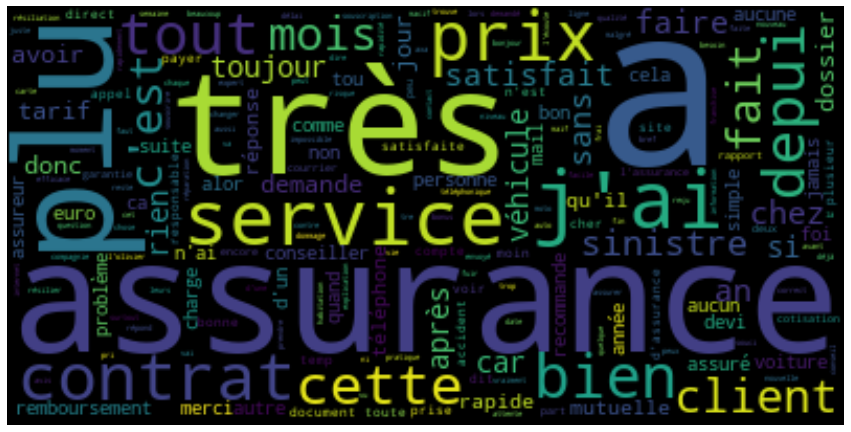

In [91]:
wordcloud = WordCloud(stopwords = all_stopwords,collocations=False).generate(' '.join(avis_processed))
plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation='bilInear')
plt.axis('off')
plt.show()

# Modeling 

## Unsupervised Learning :

### Word embedding

In [93]:
#Word embedding model
mymodel = Word2Vec(avis_lemmetized, min_count=1)

In [101]:
#We can look at some similar words
mymodel.wv.most_similar("nul")

[('pitoyable', 0.8803348541259766),
 ('archi', 0.8730543851852417),
 ('incompétent', 0.8705843687057495),
 ('catastrophique', 0.8662064075469971),
 ('lamentable', 0.8635746240615845),
 ('déplorable', 0.8602768778800964),
 ('horrible', 0.8533163666725159),
 ('inexistant', 0.8514411449432373),
 ('incompétents', 0.8394527435302734),
 ('moque', 0.8309668302536011)]

In [97]:
mymodel.wv.most_similar("satisfaisant")

[('corrects', 0.9473006725311279),
 ('satisfaisants', 0.9443860054016113),
 ('satisfais', 0.9443849325180054),
 ('performant', 0.9432348608970642),
 ('convenables', 0.9358609318733215),
 ('excellent', 0.9352511167526245),
 ('compétitif', 0.930875301361084),
 ('impeccable', 0.9302157163619995),
 ('intéressants', 0.9261850118637085),
 ('interessant', 0.9259265065193176)]

In [102]:
# LEt's make the vectorize function
def vectorize(list_avis, model):
    features = []
    for tokens in list_avis:
        zero_vector = np.zeros(model.vector_size)
        vectors = []
        for token in tokens:
            if token in model.wv:
                try:
                    vectors.append(model.wv[token])
                except KeyError:
                    continue
        if vectors:
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis=0)
            features.append(avg_vec)
        else:
            features.append(zero_vector)
    return features
    


In [270]:
vectorized_docs = vectorize(avis_lemmetized, model=mymodel)

### KMeans

In [105]:
new_kmeans = KMeans(n_clusters=2).fit(vectorized_docs)

### Data visualisation : model performance

In [123]:
test=df[['note','avis']]

In [124]:
test['cluster'] = new_kmeans.labels_

C:\Users\mehdi\anaconda3\envs\env1\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [125]:
test.head()

,note,avis,cluster
0,5,"Meilleurs assurances, prix, solutions, écoute,...",1
1,4,"je suis globalement satisfait , sauf que vous ...",1
2,5,Prix tres abordable plusieurs options s'offren...,0
3,4,"je satisfait du service, une réponse très rapi...",1
4,1,"Client depuis plus de 25 ans, très déçu de cet...",0


In [131]:
test['polarité_KMeans']=['Positif' if x ==1 else 'Négatif' for x in test['cluster']]

C:\Users\mehdi\anaconda3\envs\env1\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [271]:
for i in range(10):
  print("Review N°"+str(i)+' - Rating : '+str(df['note'][i])+' - Polarisation prédite : '+ test['polarité_KMeans'][i]+'\nAvis : '+df['avis'][i]+'\n')


Review N°0 - Rating : 5 - Polarisation prédite : Positif
Avis : Meilleurs assurances, prix, solutions, écoute, rapidité, et je recommande cette compagnie pour vous 
Des prix attractif et services de qualité et rapidité 

Review N°1 - Rating : 4 - Polarisation prédite : Positif
Avis : je suis globalement satisfait , sauf que vous avez un problème avec votre site internet ,impossible de déclarer un sinistre en ligne après plusieurs tentatives déclaration faite par téléphone ou tout c'est très bien passé , interlocutrice compétente et très agréable 

Review N°2 - Rating : 5 - Polarisation prédite : Négatif
Avis : Prix tres abordable plusieurs options s'offrent a nous comme le boitier connecter à la voiture, l'option tranquiliter et zero franchise ce qui est tout a fait plaisant

Review N°3 - Rating : 4 - Polarisation prédite : Positif
Avis : je satisfait du service, une réponse très rapide de votre service .je vous en remercie, vous êtes une assurance la moins cher sur le marche, Cordiale

In [135]:
df1=pd.DataFrame(test.groupby(['polarité_KMeans','note']).size())

In [136]:
df1.style

<AxesSubplot:title={'center':'Positive ratings '}>

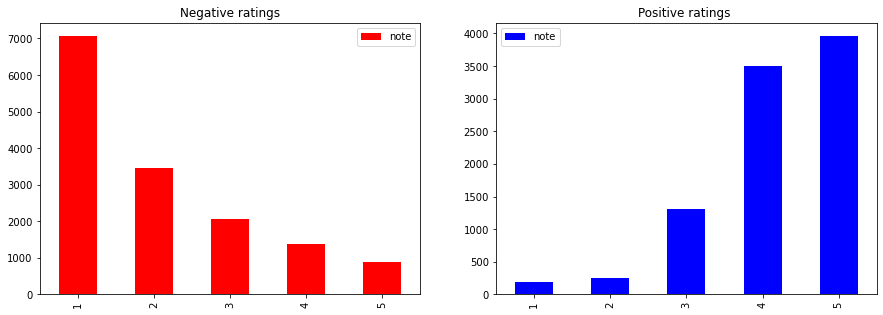

In [138]:
fig, axes = plt.subplots(nrows=1, ncols=2)
pd.DataFrame(test[test['polarité_KMeans']=='Négatif']['note'].value_counts(ascending=False)).plot(kind='bar',color='red',ax=axes[0],title='Negative ratings',figsize=(15,5))
pd.DataFrame(test[test['polarité_KMeans']=='Positif']['note'].value_counts(ascending=True)).plot(kind='bar',color='blue',ax=axes[1],title='Positive ratings ',figsize=(15,5))

### PCA

In [139]:
pca = PCA(2)
res = pca.fit_transform(vectorized_docs)

In [140]:
ax_1 = [el[0] for el in res]
ax_2 = [el[1] for el in res]
test['ax_1'] = ax_1
test['ax_2'] = ax_2

C:\Users\mehdi\anaconda3\envs\env1\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\mehdi\anaconda3\envs\env1\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


<AxesSubplot:xlabel='ax_1', ylabel='ax_2'>

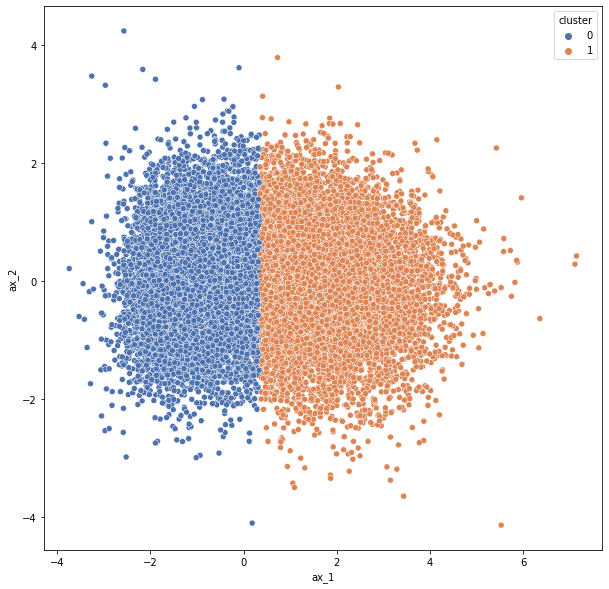

In [141]:
fig = plt.figure(figsize=(10,10))

sns.scatterplot(x='ax_1',y='ax_2',hue='cluster',palette="deep",data=test)

### To conclude, we can clearly see both clusters of ratings

## Supervised Learning : 

In [186]:
df['cluster']=test['cluster'] # Let's add the previously made cluster column

In [187]:
# Columns we want to keep for the training
cols_to_keep_train=['produit_cat','assureur_cat','cluster']

In [188]:
X=df[cols_to_keep_train]
y=df['note']

In [189]:
pca = PCA(5)
res = pca.fit_transform(vectorized_docs)

In [190]:
for i in range(5):
  X['ax'+str(i)]=[el[i] for el in res]

C:\Users\mehdi\anaconda3\envs\env1\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [191]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

### Let's do a Linear regression model

In [192]:
regr = linear_model.LinearRegression()
fitregr=regr.fit(X_train, y_train)
predregrtrain=fitregr.predict(X_train)
predregrtest=fitregr.predict(X_test)

In [193]:
print('Linear model intercept is : {} and the coefficients are of the regression are : {}'
     .format(fitregr.intercept_,fitregr.coef_))

Linear model intercept is : 2.544037038664856 and the coefficients are of the regression are : [-0.00873342  0.0025973   0.73342129  0.47845065  0.03519605 -0.02552182
 -0.01959514 -0.34456243]


In [195]:
train_set_rmse = (np.sqrt(mean_squared_error(predregrtrain,y_train )))
train_set_r2 = r2_score(y_train, predregrtrain)
print('Linear model, R2 TRAIN SCORE : {} , RMSE : {}'
     .format(train_set_r2,train_set_rmse))

test_set_rmse = (np.sqrt(mean_squared_error(predregrtest,y_test )))
test_set_r2 = r2_score(y_test, predregrtest)
print('Linear model, R2 TEST SCORE : {} , RMSE : {}'
     .format(test_set_r2,test_set_rmse))

Linear model, R2 TRAIN SCORE : 0.5384639459124674 , RMSE : 1.0410781431464409
Linear model, R2 TEST SCORE : 0.5488318360437734 , RMSE : 1.025526877888087


### Random Forest Regressor

In [196]:
# Let's make another model : a RF Regressor

In [154]:
randomForestAlgo = RandomForestRegressor()


param = {'n_estimators' : [int(x) for x in np.linspace(start=80,stop=100, num=10)], 
         'max_depth' : [90,100],
        }

gridSearch_RandomForest=GridSearchCV(randomForestAlgo,param,scoring='r2',cv=5)
gridSearch_RandomForest.fit(X_train,y_train)

best_randomForest=gridSearch_RandomForest.best_estimator_
bestRandomForest_testScore=best_randomForest.score(X_test,y_test)

After this gridsearch, the best parameters found are :

In [201]:
best_randomForest.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 90,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [203]:
print('Best Random Forest R2 train score : {:.2f}, with n estimators = {:.2f}  \n \
'.format(gridSearch_RandomForest.best_score_,gridSearch_RandomForest.best_params_['n_estimators']))
print('Best Random Forest R2 test score : {:.2f}, with n estimators = {:.2f} \n \
'.format(bestRandomForest_testScore,gridSearch_RandomForest.best_params_['n_estimators']))

Best Random Forest R2 train score : 0.61, with n estimators = 100.00  
 
Best Random Forest R2 test score : 0.61, with n estimators = 100.00 
 


In [209]:
print('MSE:', metrics.mean_squared_error(y_test, predregrtest))
print('Mean of the column:', np.mean(y_test))  

MSE: 1.0517053772708873
Mean of the column: 2.868077162414437


In [210]:
vals_importance=best_randomForest.feature_importances_

<AxesSubplot:>

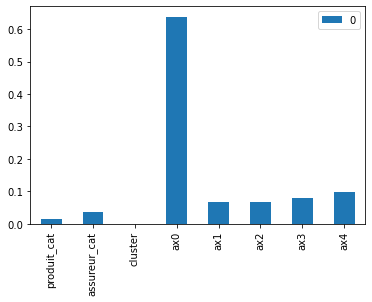

In [216]:
pd.DataFrame(vals_importance,index=X.columns).plot(kind='bar')

# Let's now work on the test set

In [218]:
test_set=pd.read_csv("C:/Users/mehdi/Downloads/avisassurance_test.csv",sep=';')

In [219]:
test_set.head()

,date,auteur,avis,assureur,produit
0,16 novemb...,lognos-d-139728,Satisfait des tarif et rapide j'attends de voi...,L'olivier Assurance,auto
1,16 novemb...,paugam-l-139727,"Bon service, service réactif. Tout en ligne pr...",L'olivier Assurance,auto
2,16 novemb...,rozgonyi-o-139704,L’assurance Olivier est une très bonne assuran...,L'olivier Assurance,auto
3,16 novemb...,saad-hellal-h-139697,Je suis satisfait de l'olivier assurances pas ...,L'olivier Assurance,auto
4,15 novemb...,damis-s-139693,le prix est attractif par rapport à ma situati...,L'olivier Assurance,auto


In [272]:
# As previously, a function to handle empty reviews
def handle_None():
  for i in range(len(tokenised_cat)):
    if tokenised_cat[i]==None:
      tokenised_cat[i]=""
handle_None()

In [220]:
tokenised_cat = test_set['avis'].apply(tokenize)

In [222]:
avis_tokenized=[[x.lower() for x in el] for el in tokenised_cat] 
avis_without_specials = [[x for x in el if re.match('[a-z]+',str(x))] for el in avis_tokenized]
avis_without_specials = [[x for x in el if re.sub('[^a-z]+'," ",str(x))] for el in avis_without_specials]
all_stopwords=stopwords.words('french')
avis_without_stopwords=[[x for x in el if x not in all_stopwords] for el in avis_without_specials]
lemmatizer = WordNetLemmatizer()
avis_lemmetized = [[lemmatizer.lemmatize(str(word)) for word in el] for el in avis_without_stopwords]

In [223]:
test_set['produit_cat']=test_set['produit'].astype('category').cat.codes.astype('int64')

In [224]:
test_set['assureur_cat']=test_set['assureur'].astype('category').cat.codes.astype('int64')

In [273]:
test_vectorized_docs = vectorize(avis_lemmetized, model=mymodel)

## KMeans 

In [277]:
new_kmeans = KMeans(n_clusters=2).fit(test_vectorized_docs)

In [278]:
test_bis=test_set[['avis']]
test_bis['cluster'] = new_kmeans.labels_

C:\Users\mehdi\anaconda3\envs\env1\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [279]:
test_bis['polarité_KMeans']=['Positif' if x ==1 else 'Négatif' for x in test_bis['cluster']]

C:\Users\mehdi\anaconda3\envs\env1\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [280]:
test_set.head()

,date,auteur,avis,assureur,produit,produit_cat,assureur_cat,cluster
0,16 novemb...,lognos-d-139728,Satisfait des tarif et rapide j'attends de voi...,L'olivier Assurance,auto,2,29,0
1,16 novemb...,paugam-l-139727,"Bon service, service réactif. Tout en ligne pr...",L'olivier Assurance,auto,2,29,0
2,16 novemb...,rozgonyi-o-139704,L’assurance Olivier est une très bonne assuran...,L'olivier Assurance,auto,2,29,0
3,16 novemb...,saad-hellal-h-139697,Je suis satisfait de l'olivier assurances pas ...,L'olivier Assurance,auto,2,29,0
4,15 novemb...,damis-s-139693,le prix est attractif par rapport à ma situati...,L'olivier Assurance,auto,2,29,0


In [281]:
test_set['cluster']=test_bis['cluster'] 

In [282]:
cols_to_keep_train=['produit_cat','assureur_cat','cluster']

In [283]:
X=test_set[cols_to_keep_train]

Another PCA

In [284]:
pca = PCA(5)
res = pca.fit_transform(test_vectorized_docs)

In [285]:
# We put the vectorization we just did in the test set
for i in range(5):
  X['ax'+str(i)]=[el[i] for el in res]

C:\Users\mehdi\anaconda3\envs\env1\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [287]:
predregrtest=fitregr.predict(X)

In [263]:
X=best_randomForest.predict(X)

In [265]:
# Finally, let's create the submission sheet
pd.DataFrame(X).to_csv('pred_nlp_proj2.csv')